# Lab 5: Spam Detection

In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/APS360\ Lab_5_Spam_Detection.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/APS360 Lab_5_Spam_Detection.ipynb to html
[NbConvertApp] Writing 532454 bytes to /content/drive/MyDrive/Colab Notebooks/APS360 Lab_5_Spam_Detection.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1V3MW-UrNFE8kmFaxy5CR1f4A2EjfZTn3?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

Spam texts are labeld "spam" and regular texts are labeled "ham"

In [ ]:
f = open('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection')
lines = f.readlines()

print(lines[0])
print(lines[2])

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


There are 743 spam messages and 4831 regular messages

In [ ]:
spam_count = 0
regular_count = 0

for line in open('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection'):
  if "ham" in line[:3]:
    regular_count += 1
  else:
    spam_count += 1


print("Spam count: ", spam_count)
print("Regular count:", regular_count)

Spam count:  747
Regular count: 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
* Often times text messages are informal and use abreviations and short forms. Because of this they only make sesnse reading them character by character (Ie: lol, smh, etc...)
*

Disadvantages: 
*
*


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index

label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection', # name of the file
                                        "tsv",                                                      # fields are separated by a tab
                                        fields)

train, val, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

Imbalance in the dataset will cause the the model to be biased towards the marjority. For example, if we train a model to classify pictures of cats and dogs but the dataset contain 90 dogs, and 10 cats, then the model will default to predicting a dog. So having a balanced dataset will result in a far less biased model. 

In [ ]:
def balance(train):
  # save the original training examples
  old_train_examples = train.examples
  # get all the spam messages in `train`
  train_spam = []
  for item in train.examples:
      if item.label == 1:
          train_spam.append(item)
  # duplicate each spam message 6 more times
  train.examples = old_train_examples + train_spam * 6
  
  return train

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

`text_field.vocab.stoi` returns a dictionary where the keys are all the characters in the given vocabulary, and the associated value is the numerical mapping of the character.<br>

`text_field.vocab.itos` returns a list the characters in the given vocabulary but now indexed by there associated numerical mapping<br>



In [ ]:
text_field.build_vocab(train)
text_field.vocab.stoi
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'i',
 's',
 'r',
 'l',
 'h',
 'u',
 '.',
 'd',
 'm',
 'y',
 'g',
 'c',
 'w',
 'p',
 'f',
 'b',
 'k',
 'I',
 '0',
 'v',
 'T',
 'E',
 'S',
 'A',
 ',',
 'O',
 "'",
 '1',
 '2',
 'N',
 '?',
 'C',
 'H',
 '!',
 'W',
 'x',
 '8',
 'M',
 'R',
 'D',
 'L',
 'U',
 '5',
 '4',
 'Y',
 'P',
 '&',
 'B',
 '7',
 'G',
 '3',
 '6',
 ';',
 ':',
 'F',
 'j',
 '9',
 '-',
 'z',
 ')',
 'K',
 '/',
 'V',
 '£',
 'X',
 'J',
 '#',
 '*',
 '"',
 'q',
 '+',
 '(',
 'ü',
 'Q',
 '=',
 'Ü',
 '|',
 '>',
 '@',
 '‘',
 '\x92',
 'Z',
 '$',
 '_',
 '…',
 '%',
 '–',
 '<',
 '\\',
 '\x96',
 '’',
 '\t',
 '\n',
 '[',
 ']',
 '~',
 '¡',
 '\x91',
 '\x93',
 '»',
 'è',
 'ú',
 '—',
 '“',
 '┾',
 '〨',
 '鈥']

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents an unknown character<br>
`<pad>` represents padding in a text

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
i = 0
for batch in train_iter:
    print("Max Input sequence length:", batch.sms[0].shape[1])

    texts = batch.sms[0]
    test = torch.where(texts == 1.0, 1, 0)
    print("Number of <pad> characters:", int(torch.sum(test)), "\n")

    i += 1
    
    if i == 10 :
      break

Max Input sequence length: 145
Number of <pad> characters: 34 

Max Input sequence length: 155
Number of <pad> characters: 27 

Max Input sequence length: 72
Number of <pad> characters: 15 

Max Input sequence length: 36
Number of <pad> characters: 7 

Max Input sequence length: 116
Number of <pad> characters: 47 

Max Input sequence length: 157
Number of <pad> characters: 3 

Max Input sequence length: 25
Number of <pad> characters: 0 

Max Input sequence length: 31
Number of <pad> characters: 0 

Max Input sequence length: 59
Number of <pad> characters: 10 

Max Input sequence length: 68
Number of <pad> characters: 27 



## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
  """ Compute the accuracy of the `model` across a dataset `data`
  
  Example usage:
  
  >>> model = MyRNN() # to be defined
  >>> get_accuracy(model, valid) # the variable `valid` is from above
  """
  accuracy = 0.0
  total = 0.0
  for text, label in data:

    output = model(text[0])
    prediction = output.max(1, keepdim=True)[1]
    accuracy += prediction.eq(label.view_as(prediction)).sum().item()
    total += label.shape[0]
  

  return float(accuracy/total)

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
class simpleSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(simpleSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "simpleSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out


In [ ]:
def train_model(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=0.001):
  print("train_model")
  model_name = model.name  + '_lr_' +  str(learning_rate) + '_bs_' + str(batch_size) + '_epc_' + str(num_epochs) + '.pt'
  PATH = '/content/drive/MyDrive/Colab Notebooks/Model checkpoint/' + model_name

  # Batch the SMS' based on their length...
  train_iter = torchtext.legacy.data.BucketIterator(train_loader,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)     

  valid_iter = torchtext.legacy.data.BucketIterator(valid_loader,
                                           batch_size=batch_size,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)           

  iters = []
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  torch.manual_seed(1000)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Number of iterations
  n = 0

  for epoch in range(num_epochs):
    # Train the model on the training data
    for data in train_iter:
      optimizer.zero_grad()

      text, labels = data

      output = model(text[0])

      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      n += 1

    iters.append(epoch)
    train_loss.append(float(loss) / batch_size)
    train_acc.append(get_accuracy(model, train_iter))


    # Validate the model...
    for data in valid_iter:
      text, labels = data

      output = model(text[0])
      loss = criterion(output, labels)

    val_loss.append(float(loss) / batch_size)
    val_acc.append(get_accuracy(model, valid_iter))

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss[-1],
      }, PATH)
  # Plotting
  plt.title("Training Error Curve")
  plt.plot(iters, train_loss, label="Train")
  plt.plot(iters, val_loss, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Training Loss Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  return train_loss, train_acc, val_loss, val_acc

In [ ]:
text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index

label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset('/content/drive/MyDrive/Colab Notebooks/SMSSpamCollection', # name of the file
                                        "tsv",                                                      # fields are separated by a tab
                                        fields)

train_set, val_set, test_set = dataset.split(split_ratio=[0.6, 0.2, 0.2])

balance(train_set)

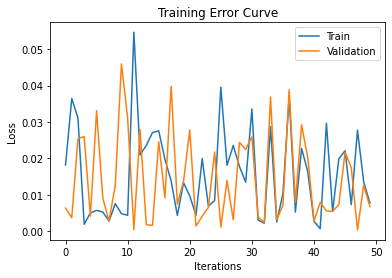

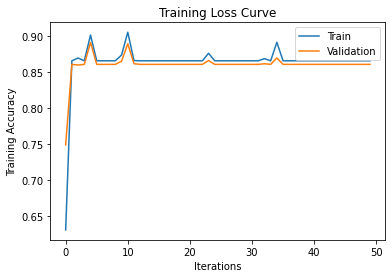

In [ ]:
# Testing to make sure the training, accuracy, and loss work...

# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = simpleSpamDetector(input_size, hidden_size, num_classes)

train_loss, train_acc, val_loss, val_acc = train_model(model, train_set, val_set, batch_size=32, num_epochs=50, learning_rate=0.01)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

HyperParameters:


*   RNN model type: Vanilla, GRU, or LSTM
*   Hidden units: 50, 100, 150, 200
*   Learning rate: 0.01, 0.005, 0.001
*   RNN pooling: None, max-pool, average max-pool



$
\begin{array}{ |c c c| }
Model & Loss &  Accuracy\\
\hline
Vanilla & 9.553e-7 & 98.20 \\
GRU     & 4.0985e-7 & 99.01\\
LSTM    &   0.0113 &  84.75 \\
\end{array}
$

The best accuract achieved was 99.20% using the GRU model. When I analyzed the loss and accuracy graph of LTSM it was quite eratic. Because of this, I decided to choose the GRU model because it had very high accuracy, low loss, and training stability. 

$
\begin{array}{|c c c|}
  Hidden \hspace{2mm} size & Loss & Accuracy \\
  \hline
  50 & 1.1024e-8 &98.38\\
  100 & 1.6460e-7 & 98.56\\
  150 & 0.0004 & 86.72\\
  200 & 0.0030 &91.55\\
\end{array}
$ <br>
All 4 hyperparameters tested yielded about the same accuracy with only slight variation in loss. But I choose to use 50 because it had a high accuracy, the lowest loss, and was the quickest to train.


$
\begin{array}{|c c c|}
Learning \hspace{2mm} & Loss & Accuracy \\
\hline
0.01  & 1.1024e-7 & 98.38\\
0.005 & 6.7520e-9 & 98.74\\
0.001 & 4.74e-10 & 98.56\
\end{array}
$ <br>
Similar to the hidden unit the accuracy of all the tuned parameters were very close however, both 0.005 and 0.001 demonstrated underfitting in the accuracy graph. Because of this a learning rate of 0.01 was selected.  

$
\begin{array}{|c c c|}
Pool \hspace{2mm} type & Loss & Validation \\
\hline
None    &  1.1024e-7 & 98.38\\
Max     &1.6298e-8 & 98.47\\
Average & 5.3084e-8& 98.47\\
\end{array}
$<br>
Small note, I had to double the hidden size for the average max pooling to compensate for the averaging. 
It turns out that no pooling was the worst, and average max pooling was the best because it had a very low loss and the best accuracy.

### Rnn Model type:


In [ ]:
# Vanilla RNN
class VanillaSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(VanillaSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "VanillaSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# GRU RNN
class GRUSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(GRUSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "GRUSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# LSTM RNN
class LSTMSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(LSTMSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "LSTMSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    c0 = torch.zeros(1, x.size(0), self.hidden_size)

    out, _ = self.rnn(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = [LSTMSpamDetector(input_size, hidden_size, num_classes), GRUSpamDetector(input_size, hidden_size, num_classes), VanillaSpamDetector(input_size, hidden_size, num_classes)]

for ai in model:
  train_loss, train_acc, val_loss, val_acc = train_model(ai, train_set, val_set, batch_size=32, num_epochs=30, learning_rate=0.01)

  print("Training Loss:", train_loss[-1])
  print("Training Accuracy:", train_acc[-1])
  print("Validation Loss:", val_loss[-1])
  print("Validation Accuracy:", val_acc[-1])


### Hidden units:

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

hidden_size = [50, 100, 150, 200]

# Either Spam or Ham!
num_classes = 2


for s in hidden_size:
  model = GRUSpamDetector(input_size, s, num_classes)
  train_loss, train_acc, val_loss, val_acc = train_model(model, train_set, val_set, batch_size=32, num_epochs=30, learning_rate=0.01)

  print("Training Loss:", train_loss[-1])
  print("Training Accuracy:", train_acc[-1])
  print("Validation Loss:", val_loss[-1])
  print("Validation Accuracy:", val_acc[-1])


### Learning rate:


In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

hidden_size = 50

learning_rate = [0.01, 0.005, 0.001]

# Either Spam or Ham!
num_classes = 2

model = GRUSpamDetector(input_size, hidden_size, num_classes)

for lr in learning_rate:
  train_loss, train_acc, val_loss, val_acc = train_model(model, train_set, val_set, batch_size=32, num_epochs=30, learning_rate=lr)

  print("Training Loss:", train_loss[-1])
  print("Training Accuracy:", train_acc[-1])
  print("Validation Loss:", val_loss[-1])
  print("Validation Accuracy:", val_acc[-1])

### RNN Pooling:

In [ ]:
# GRU RNN
class GRUSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(GRUSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "GRUSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)

    out, _ = self.rnn(x, h0)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
# GRU RNN
class GRUMPSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(GRUMPSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, num_classes)
    self.name = "GRUMPSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)

    out, _ = self.rnn(x, h0)
    out = self.fc(torch.max(out, dim=1)[0])
    return out

In [ ]:
# GRU RNN
class GRUAMPSpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(GRUAMPSpamDetector, self).__init__()

    self.ident = torch.eye(input_size)
    self.hidden_size = hidden_size
    self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(2 * hidden_size, num_classes)
    self.name = "GRUAMPSpamDetector"

  def forward(self, x):
    x = self.ident[x]

    h0 = torch.zeros(1, x.size(0), self.hidden_size)

    out, _ = self.rnn(x, h0)
    out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
    out = self.fc(out)
    return out

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model_1 = GRUSpamDetector(input_size, hidden_size, num_classes)
model_2 = GRUMPSpamDetector(input_size, hidden_size, num_classes)
model_3 = GRUAMPSpamDetector(input_size, hidden_size, num_classes)

model = [model_1, model_2, model_3]

for ai in model:
  train_loss, train_acc, val_loss, val_acc = train_model(ai, train_set, val_set, batch_size=32, num_epochs=30, learning_rate=0.01)

  print("Training Loss:", train_loss[-1])
  print("Training Accuracy:", train_acc[-1])
  print("Validation Loss:", val_loss[-1])
  print("Validation Accuracy:", val_acc[-1])

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

The false positive rate is 0.04% and the false negative rate is 8.8%

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in val_set.examples if e.label == 1],
    val_set.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in val_set.examples if e.label == 0],
    val_set.fields)

In [ ]:
valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                          batch_size=32,
                                          sort_key=lambda x: len(x.sms), # to minimize padding
                                          sort_within_batch=True,        # sort within each batch
                                          repeat=False)   

valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                        sort_within_batch=True,        # sort within each batch
                                        repeat=False)   
  

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = GRUAMPSpamDetector(input_size, hidden_size, num_classes)
 
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/GRUAMPSpamDetector_lr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
print("False positive rate:", 1 - get_accuracy(model, valid_nospam_iter))
print("False negative rate:", 1 - get_accuracy(model, valid_spam_iter))

False positive rate: 0.0040858018386108474
False negative rate: 0.08823529411764708


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positive means that a text messages that in reality isn't spam is labeled as spam. For example, if your doctor sends you a text about something urgent but gets flagged as spam the user might be put into real danger. <br>
On the other hand false negative means that text messages that are in actuallity spam are labeled as normal. This would be an annoyance to the user but could also lead to them getting scammed because they trust all messages shown to them. 

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

The final accuracy of the model is 98.56%

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = GRUAMPSpamDetector(input_size, hidden_size, num_classes)

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/GRUAMPSpamDetector_lr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
test_iter = torchtext.legacy.data.BucketIterator(test_set,
                                          batch_size=32,
                                          sort_key=lambda x: len(x.sms), # to minimize padding
                                          sort_within_batch=True,        # sort within each batch
                                          repeat=False)   

get_accuracy(model, test_iter)

0.9856373429084381

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

The false positive rate is 1.1% and the false negative rate is 7.4%

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 1],
    val_set.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test_set.examples if e.label == 0],
    val_set.fields)

In [ ]:
test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                          batch_size=32,
                                          sort_key=lambda x: len(x.sms), # to minimize padding
                                          sort_within_batch=True,        # sort within each batch
                                          repeat=False)   

test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                        batch_size=32,
                                        sort_key=lambda x: len(x.sms), # to minimize padding
                                        sort_within_batch=True,        # sort within each batch
                                        repeat=False)  

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = GRUAMPSpamDetector(input_size, hidden_size, num_classes)

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/GRUAMPSpamDetector_lr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
print("False positive rate:", 1 - get_accuracy(model, test_nospam_iter))
print("False negative rate:", 1 - get_accuracy(model, test_spam_iter))

False positive rate: 0.011387163561076608
False negative rate: 0.07432432432432434


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
for data in test_nospam_iter:
  text, label = data
  print(text[0].shape)
  break
print(msg_tensor.shape)

In [ ]:
msg = "machine learning is sooo cool!"

In [ ]:
# Convert the msg to a numerical tensor representation

vocabulary = text_field.vocab.stoi
indexes = text_field.vocab.itos

msg_indexes = [[]]

for i in msg:
  if(i == " " ):
    msg_indexes[0].append(1)
  else:
    msg_indexes[0].append(vocabulary[i])

msg_tensor = torch.LongTensor(msg_indexes)

In [ ]:
# Input size is the number of unique characters in the entire dataset
text_field.build_vocab(train_set)
text_field.vocab.stoi
input_size = len(text_field.vocab.itos)

# This is a hyperparameter
hidden_size = 50

# Either Spam or Ham!
num_classes = 2

model = GRUAMPSpamDetector(input_size, hidden_size, num_classes)

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/GRUAMPSpamDetector_final.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
output = model(msg_tensor)

Recall:
$
P\{y = 1 | x \} = \frac{e^{W^T x}}{1 + e^{W^T x}}
$

In [ ]:
P_not_spam = float(torch.exp(output[0][0]) / (1 + torch.exp(output[0][0])))
P_spam = 1 - P_not_spam

In [ ]:
print("The probability that this is spam is:", 100 * P_spam, "%")
print("The probability that this is not spam:", 100 * P_not_spam, "%")

The probability that this is spam is: 0.1957416534423828 %
The probability that this is not spam: 99.80425834655762 %


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Processing human language is very difficult in general, and as spammer/scammers think of smarter ways to trick people it only gets more and more difficult to seperate real human communication from nefarious communication.


A super easy way to create a baseline model is to use a model library. For example, a very common and accessible library is Sklearn. Using this library you can simply import a premade model. In this case we can simply use a regression model that implements SGD.


```
from sklearn import linear_model

model = linear_model.SGDRegressor()

# Training ...
model.fit(training_data, training_labels)


# Testing ....
result = model.predict(testing_data)
get_accuracy(result, testing_labels)
```
After importing the library pass in the training data, and the training labels. Now the model is trainied. Note that there's no need to split the data in to a validation set since sklearn will do this for you. To test the model pass in the testing data and compare the results to the testing data.  

